# Loyalty Cards Analysis

# Config

In [58]:
import numpy as np
import pandas as pd
import os
from scipy import stats
import sys

sys.path.append('c:/Users/Jordi Cremades/Documents/Repos/central-node')

from src import dataframe_statistics,dataframe_visualizer,query_engines

q = query_engines.QueryEngines()

# Experiment parameters

- Test is in all devices, all countires all customers
- 50/50 Split
- Test begins on 2024-07-31
- MDE --> After 4 weeks of test, we can detect a rel. effect of 4% in LC order pen. With power 0.8 (20% chance of FN . \
With alpha 0.05 (5% chance of FP))
- CAREFUL - do not play with customers_all_groceries,order_all_groceries or gmv_delivered_all_groceries when grouping by store it adds up incorrectly

# Sanity check: Customer splitting

In [2]:
START_DATE = "'2024-07-01'"
END_DATE = "'2025-01-01'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
]

q.prepare_query(
    'lc_analysis/customer_splitting.sql'
    ,params=params
    ,to_load_file=None
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()

df.head()

c:\Users/Jordi Cremades/Documents/Repos/central-node\src\query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


,date,variant,n_first_exposure_customers
0,2024-07-19,New loyalty program,1184
1,2024-07-19,Control Group,1
2,2024-07-19,forced_assignment,15
3,2024-07-20,forced_assignment,4
4,2024-07-20,New loyalty program,404


In [82]:
# Pivot the DataFrame
pivot_df = df.pivot(index='date', columns='variant', values='n_first_exposure_customers')

# Rename the columns
pivot_df.columns = [f'n_first_exposure_customers_{col}' for col in pivot_df.columns]


# Reset the index to make 'date' a regular column
pivot_df = pivot_df.reset_index()

# Fill NaN values with 0 and convert columns to int (except 'date')
pivot_df = pivot_df.fillna(0)
for col in pivot_df.columns:
    if col != 'date':
        pivot_df[col] = pivot_df[col].astype(int)

# Sort the DataFrame by 'date'
pivot_df = pivot_df.sort_values(by='date', ascending=True)

pivot_df

,date,n_first_exposure_customers_Control Group,n_first_exposure_customers_New loyalty program,n_first_exposure_customers_forced_assignment
0,2024-07-19,1,1184,15
1,2024-07-20,0,404,4
2,2024-07-21,0,284,4
3,2024-07-22,0,376,11
4,2024-07-23,1,1246,23
5,2024-07-24,0,865,14
6,2024-07-25,0,418,7
7,2024-07-26,1,776,14
8,2024-07-27,0,499,3
9,2024-07-28,0,337,5


In [83]:
pivot_df.columns

Index(['date', 'n_first_exposure_customers_Control Group',
       'n_first_exposure_customers_New loyalty program',
       'n_first_exposure_customers_forced_assignment'],
      dtype='object')

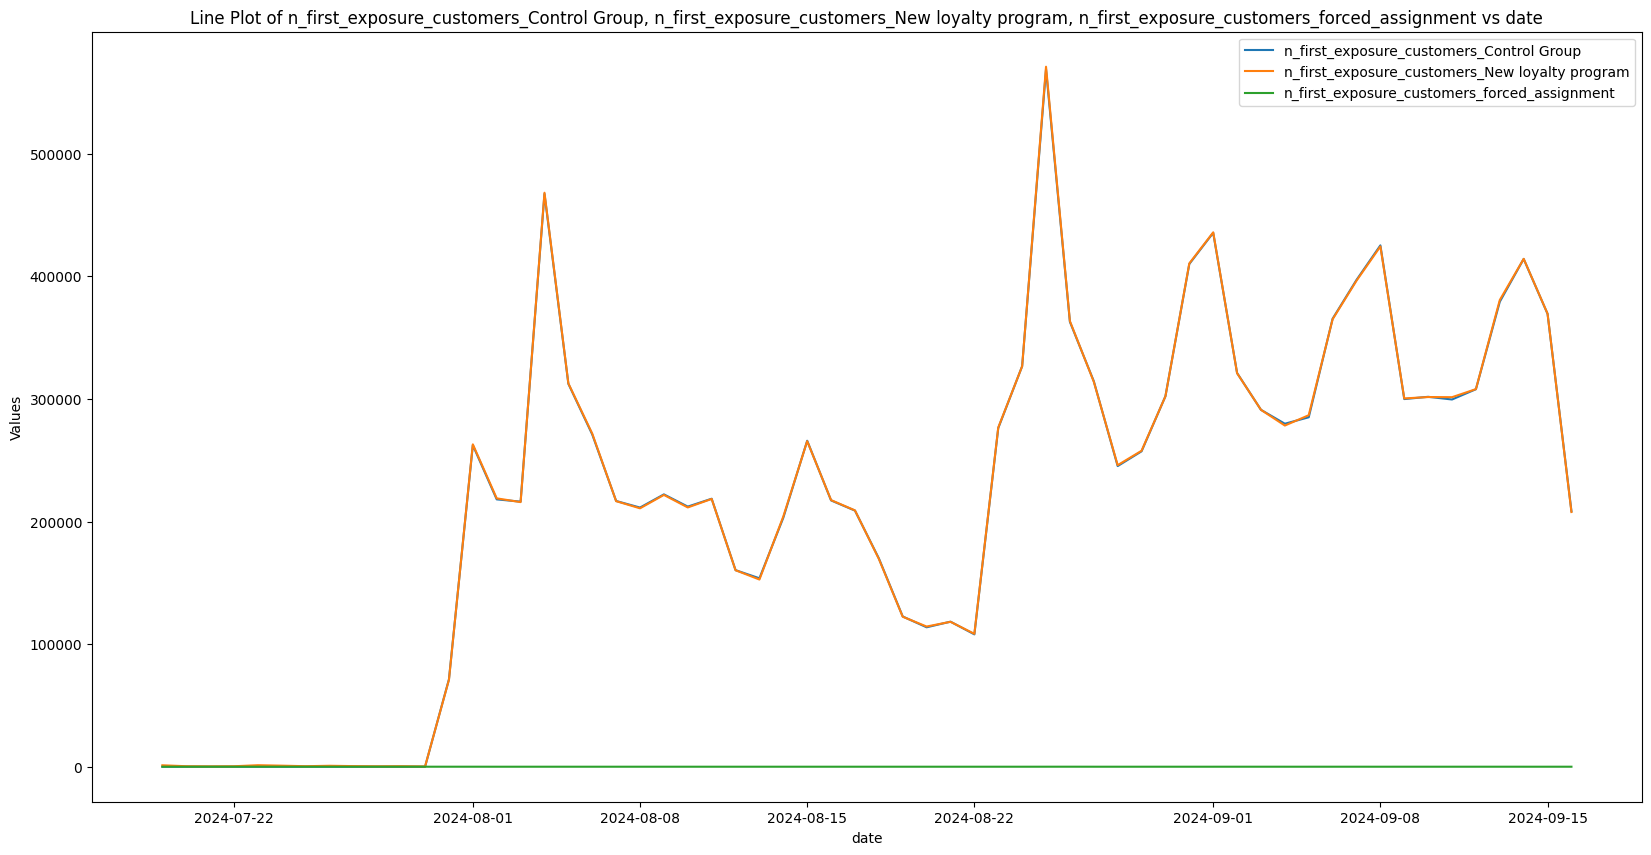

In [84]:
v = dataframe_visualizer.DataFrameVisualizer(pivot_df, fig_size=(20,10))

v.multiple_variable_lineplot(
    'date'
    ,['n_first_exposure_customers_Control Group','n_first_exposure_customers_New loyalty program','n_first_exposure_customers_forced_assignment']
)

Since the split is 50/50. This is the expected results. OK! We have the same name number of first exposures for the different versions of the experiment.

# Sanity check: Experiment versions

In [41]:
START_DATE = "'2024-07-01'"
END_DATE = "'2025-01-01'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
]

q.prepare_query(
    'lc_analysis/lc_experiment_versions.sql'
    ,params=params
    ,to_load_file=None
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()

df.head()

c:\Users/Jordi Cremades/Documents/Repos/central-node\src\query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


,experiment_id,first_exposure_date
0,SONIC_LOYALTY_CARDS_NEW-11486-SONIC_LOYALTY_CA...,2024-07-31
1,SONIC_LOYALTY_CARDS_NEW-11379-SONIC_LOYALTY_CA...,2024-07-26
2,SONIC_LOYALTY_CARDS_NEW-11241-SONIC_LOYALTY_CA...,2024-07-23
3,SONIC_LOYALTY_CARDS_NEW-11241-SONIC_LOYALTY_CA...,2024-07-23
4,SONIC_LOYALTY_CARDS_NEW-11164-SONIC_LOYALTY_CA...,2024-07-19


OK! Consistent with the last version of the History we have in Admin.

# Loyalty Cards sanity check metrics

In [111]:
START_DATE = "'2024-07-31'"
END_DATE = "'2024-09-10'"
PREVIOUS_DAYS_START_DATE = '-30'

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
    {'name':'previous_days_start_date', 'value': PREVIOUS_DAYS_START_DATE},
]

q.prepare_query(
    'lc_analysis/lc_metrics.sql'
    ,params=params
    ,to_load_file=None
    ,load_from_to_load_file=None
)

df  = q.query_run_starburst()

df

c:\Users/Jordi Cremades/Documents/Repos/central-node\src\query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


,p_creation_date,variant,customers_all_groceries,order_all_groceries,gmv_delivered_all_groceries
0,2024-08-16,New loyalty program,36677,40931,8.335766e+05
1,2024-08-16,Control Group,36499,40908,8.301236e+05
2,2024-08-02,New loyalty program,15724,17501,3.527821e+05
3,2024-07-31,Not Exposed,64109,71501,1.462066e+06
4,2024-08-05,Not Exposed,9199,10225,2.072807e+05
...,...,...,...,...,...
163,2024-08-06,New loyalty program,31992,35606,7.111575e+05
164,2024-09-07,Not Exposed,203,233,4.703245e+03
165,2024-08-15,Not found,8685,12512,1.774869e+05
166,2024-08-14,Not found,10163,15885,2.321255e+05


## (no execute again) Distribution between variants (inner join) 

When I use the inner join of custoemrs that appear in the first exposure. Obviously this means that at some point it will
appear. Thus at the end the Not Exposed tends to zero. This makes sense.

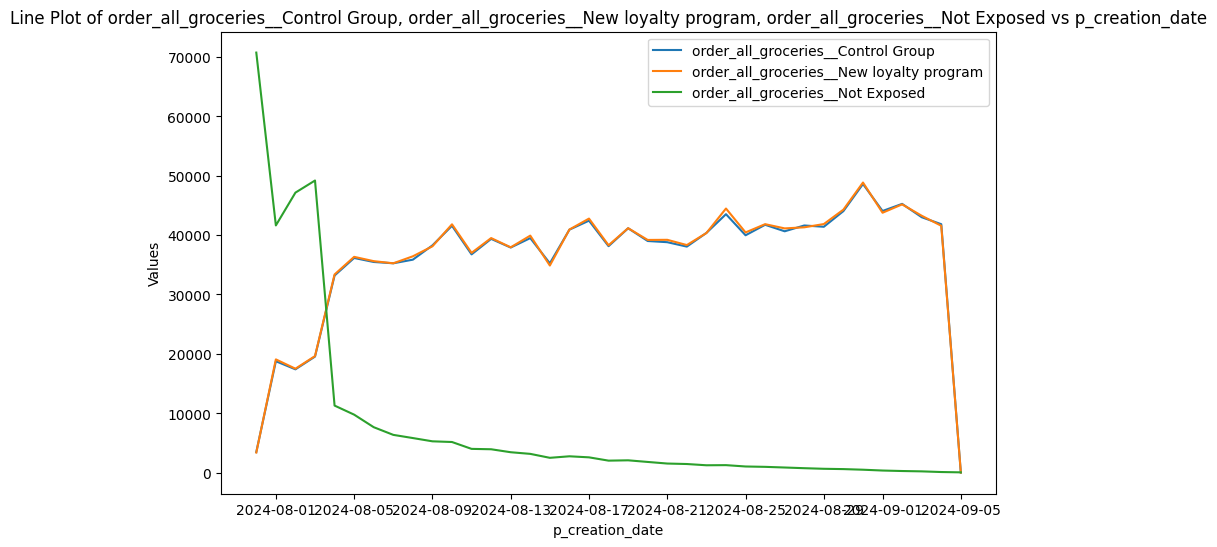

In [103]:
# Pivot by variant
df_pivoted = df.pivot(index='p_creation_date', columns='variant', values=['order_all_groceries','customers_all_groceries','gmv_delivered_all_groceries'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['order_all_groceries__Control Group', 'order_all_groceries__New loyalty program', 'order_all_groceries__Not Exposed']
)


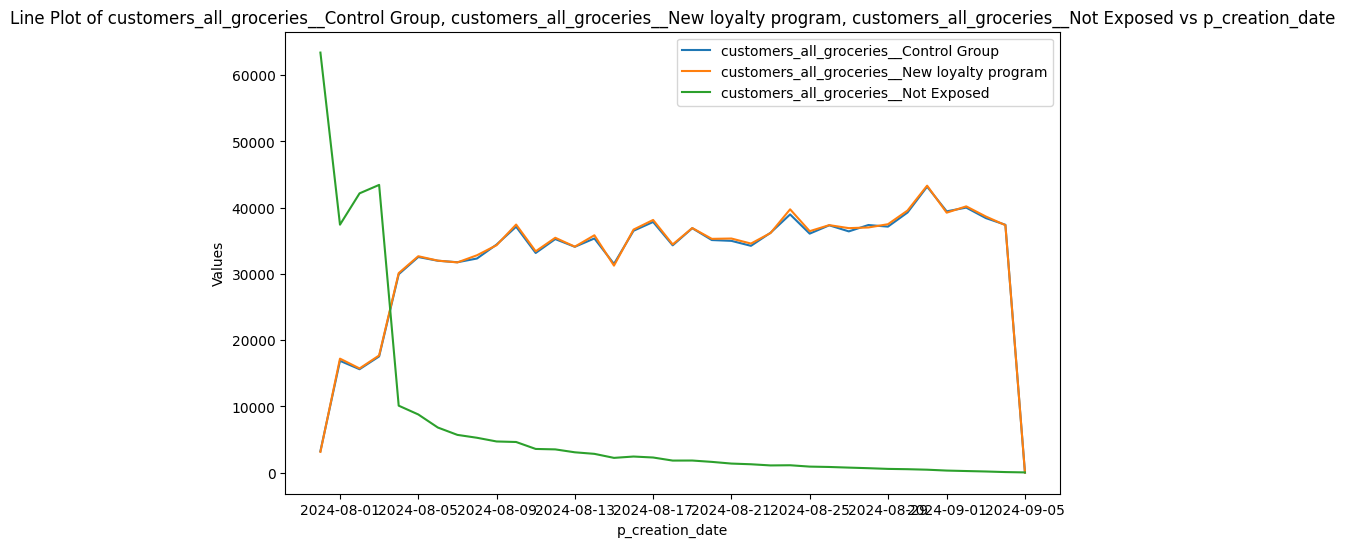

In [104]:
# Pivot by variant
df_pivoted = df.pivot(index='p_creation_date', columns='variant', values=['order_all_groceries','customers_all_groceries','gmv_delivered_all_groceries'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['customers_all_groceries__Control Group', 'customers_all_groceries__New loyalty program', 'customers_all_groceries__Not Exposed']
)


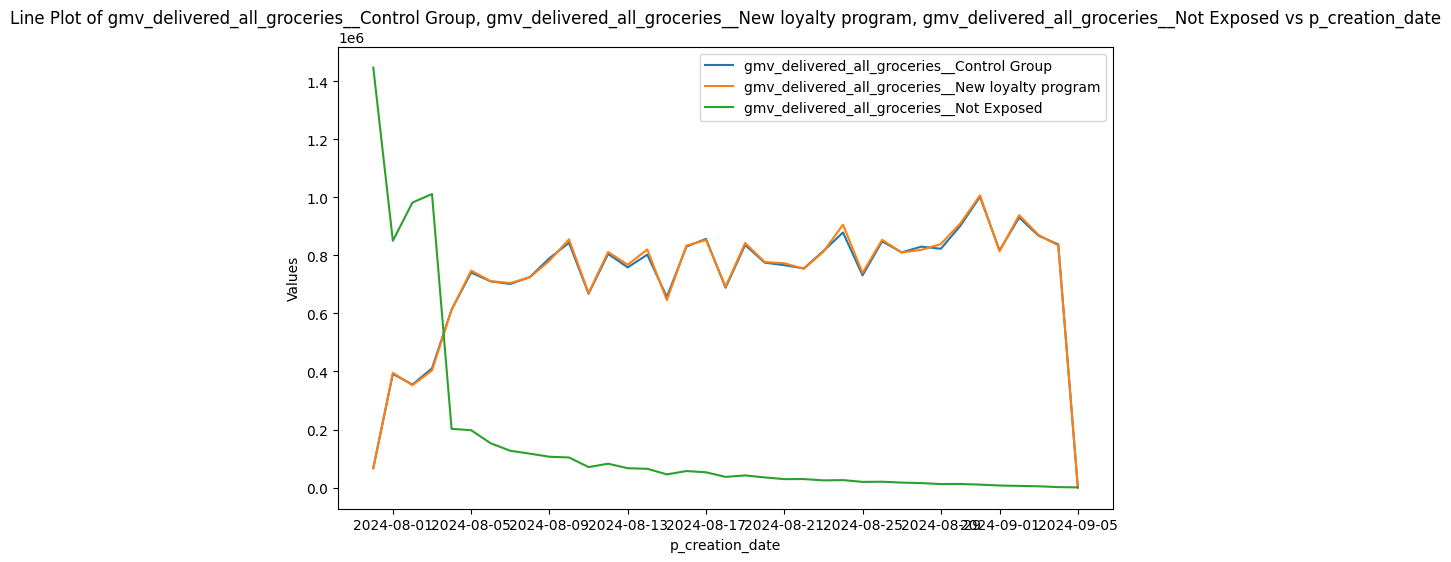

In [105]:
# Pivot by variant
df_pivoted = df.pivot(index='p_creation_date', columns='variant', values=['order_all_groceries','customers_all_groceries','gmv_delivered_all_groceries'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['gmv_delivered_all_groceries__Control Group', 'gmv_delivered_all_groceries__New loyalty program', 'gmv_delivered_all_groceries__Not Exposed']
)


## (no execute again) Distribution between variants (left join )

When I use the left join of custoemrs that appear in the first exposure

In [128]:
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

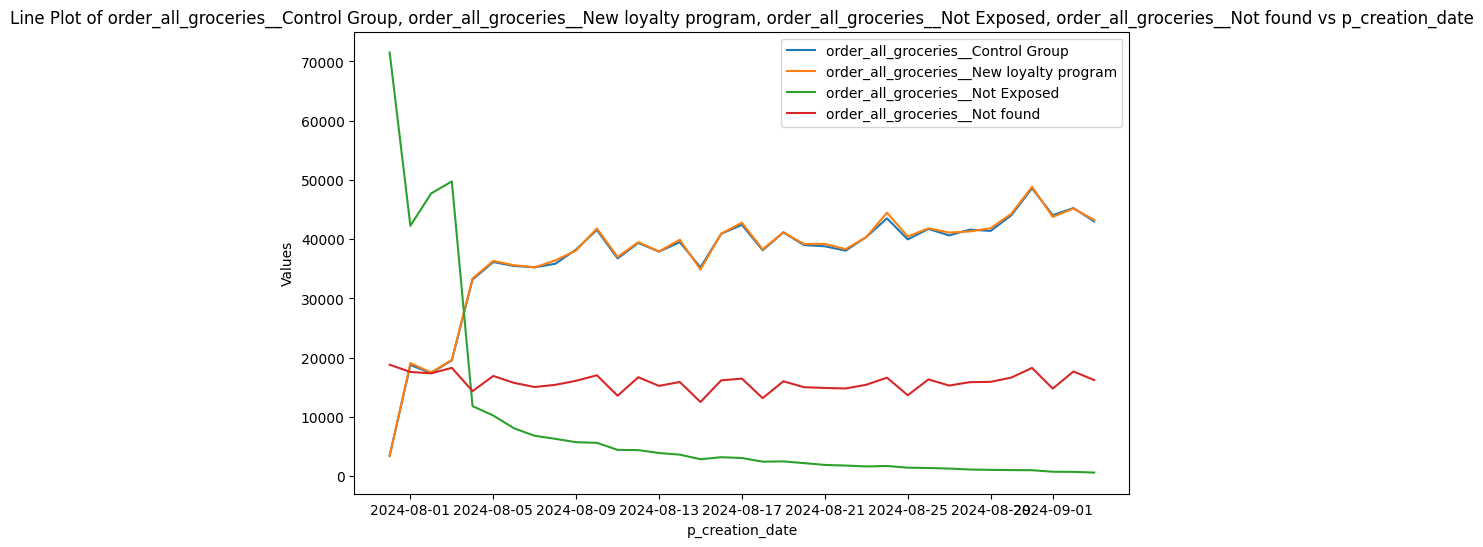

In [133]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-03'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['order_all_groceries','customers_all_groceries','gmv_delivered_all_groceries'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['order_all_groceries__Control Group', 'order_all_groceries__New loyalty program', 'order_all_groceries__Not Exposed', 'order_all_groceries__Not found']
)


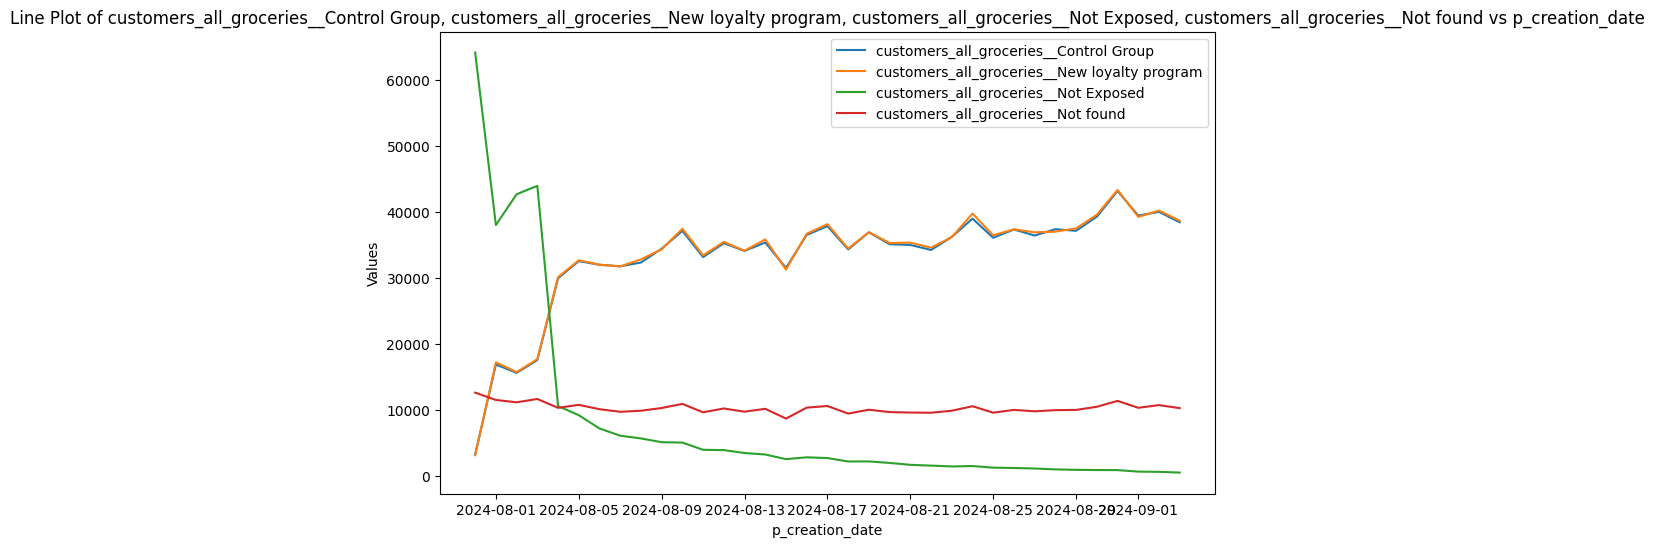

In [135]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-03'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['order_all_groceries','customers_all_groceries','gmv_delivered_all_groceries'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['customers_all_groceries__Control Group', 'customers_all_groceries__New loyalty program', 'customers_all_groceries__Not Exposed', 'customers_all_groceries__Not found']
)


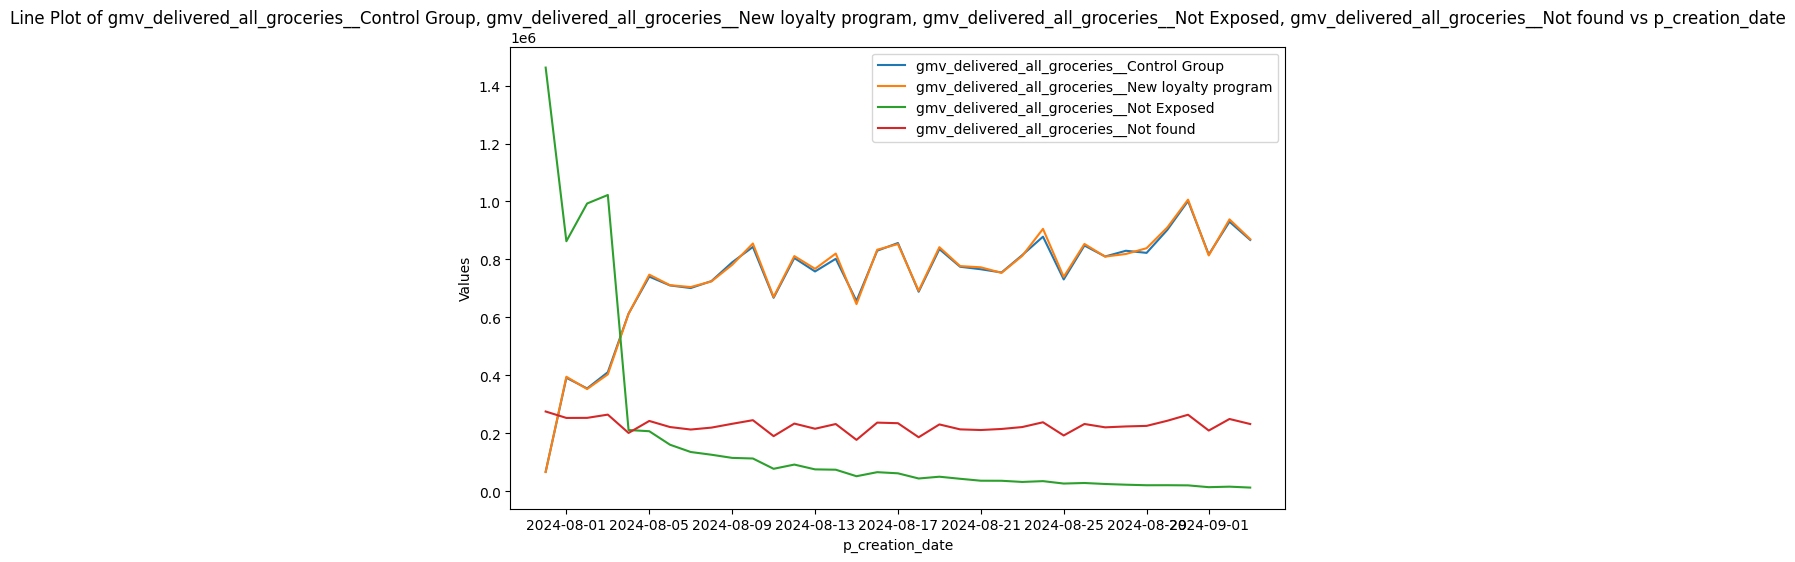

In [136]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-03'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['order_all_groceries','customers_all_groceries','gmv_delivered_all_groceries'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['gmv_delivered_all_groceries__Control Group', 'gmv_delivered_all_groceries__New loyalty program', 'gmv_delivered_all_groceries__Not Exposed', 'gmv_delivered_all_groceries__Not found']
)


# Loyalty Cards sanity check metrics part II

In [189]:
START_DATE = "'2024-07-31'"
END_DATE = "'2024-09-10'"
PREVIOUS_DAYS_START_DATE = '-30'

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
    {'name':'previous_days_start_date', 'value': PREVIOUS_DAYS_START_DATE},
]

q.prepare_query(
    'lc_analysis/lc_metrics.sql'
    ,params=params
    ,to_load_file=None
    ,load_from_to_load_file=None
)

df  = q.query_run_starburst()

df

c:\Users/Jordi Cremades/Documents/Repos/central-node\src\query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


,p_creation_date,variant,customers_all_orders_from_lcs,orders_all_orders_from_lcs,gmv_delivered_all_orders_from_lcs
0,2024-09-03,New loyalty program,7783,8278,212890.575595
1,2024-09-06,Not found,2000,2205,58230.490341
2,2024-09-02,Not found,2105,2330,62409.881838
3,2024-08-22,Control Group,6703,7050,179267.510657
4,2024-08-27,Control Group,7216,7626,193381.672943
...,...,...,...,...,...
163,2024-08-25,Control Group,5947,6243,155632.871893
164,2024-08-29,Not found,1785,1944,48914.383619
165,2024-08-24,Not Exposed,280,296,7599.529719
166,2024-08-25,Not Exposed,173,183,4482.758616


## (no execute again) Distribution between variants (inner join)

When I use the inner join of custoemrs that appear in the first exposure. Obviously this means that at some point it will
appear. Thus at the end the Not Exposed tends to zero. This makes sense.

In [181]:
df['variant'].value_counts()

variant
Control Group          42
Not Exposed            42
New loyalty program    42
Name: count, dtype: int64

In [182]:
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

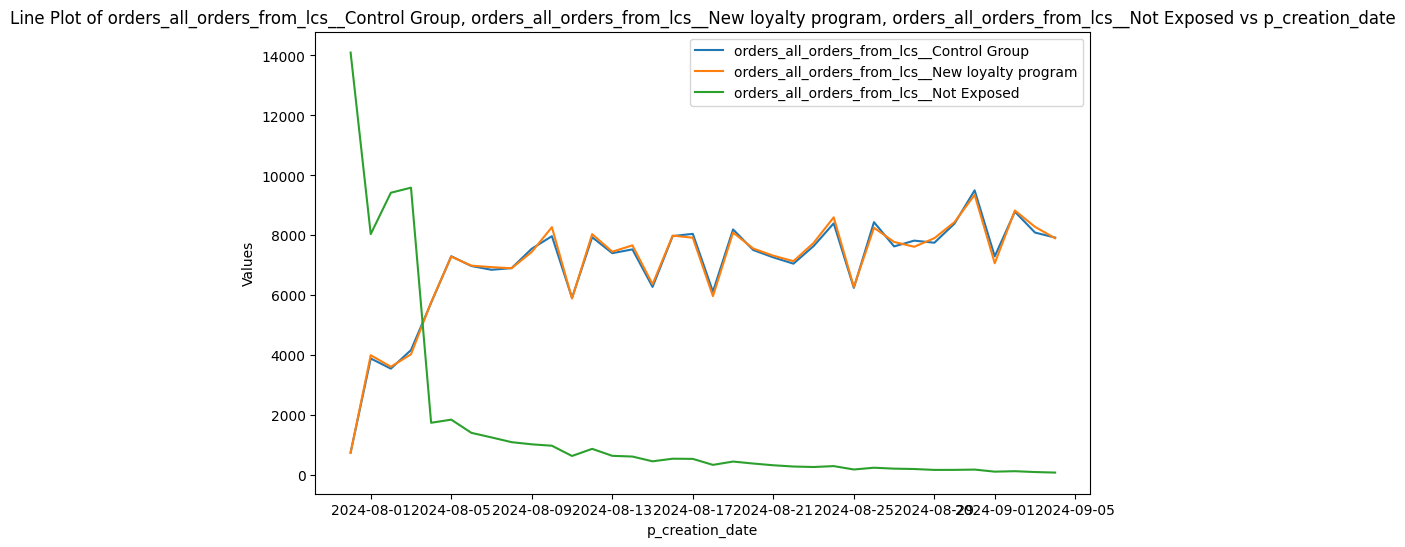

In [185]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-04'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['orders_all_orders_from_lcs','customers_all_orders_from_lcs','gmv_delivered_all_orders_from_lcs'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['orders_all_orders_from_lcs__Control Group', 'orders_all_orders_from_lcs__New loyalty program', 'orders_all_orders_from_lcs__Not Exposed']
)


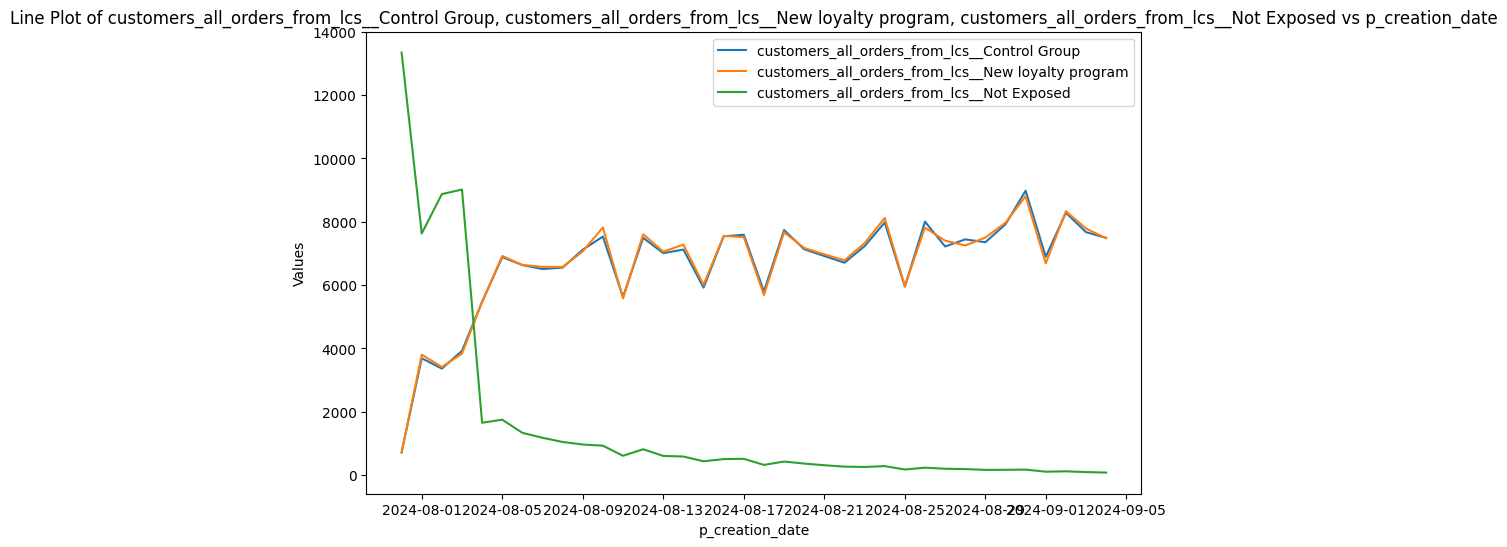

In [186]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-04'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['orders_all_orders_from_lcs','customers_all_orders_from_lcs','gmv_delivered_all_orders_from_lcs'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['customers_all_orders_from_lcs__Control Group', 'customers_all_orders_from_lcs__New loyalty program', 'customers_all_orders_from_lcs__Not Exposed']
)


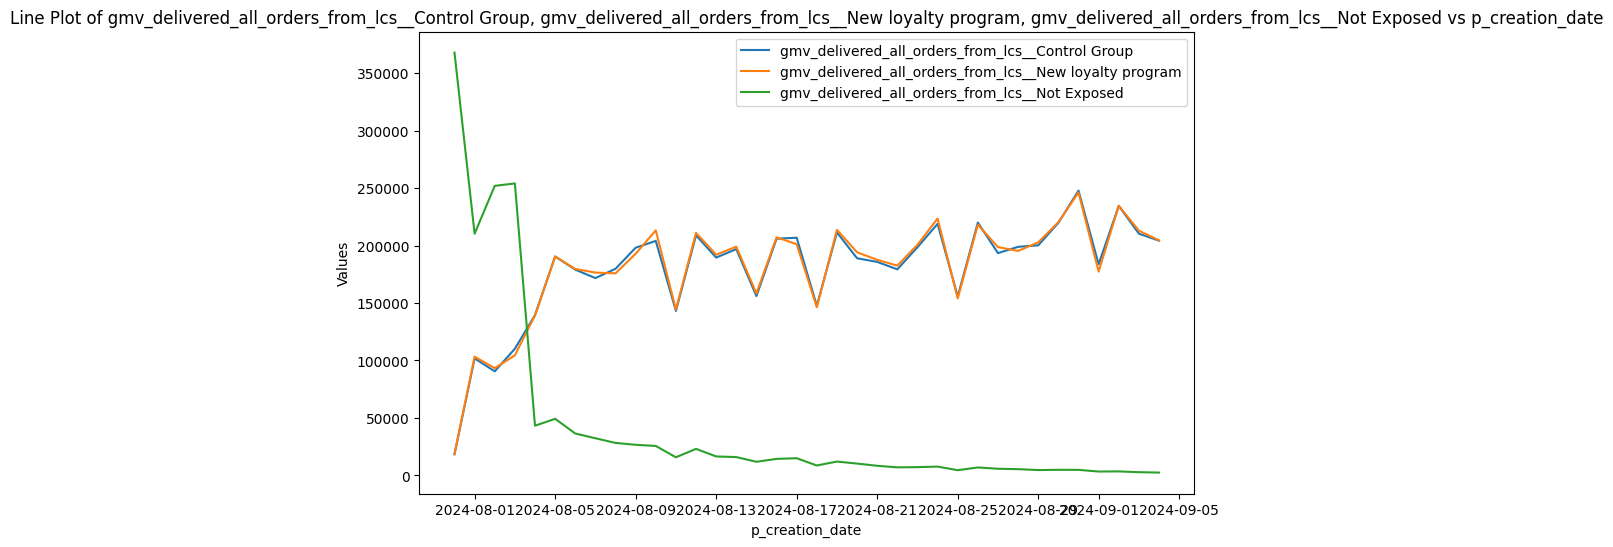

In [187]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-04'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['orders_all_orders_from_lcs','customers_all_orders_from_lcs','gmv_delivered_all_orders_from_lcs'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['gmv_delivered_all_orders_from_lcs__Control Group', 'gmv_delivered_all_orders_from_lcs__New loyalty program', 'gmv_delivered_all_orders_from_lcs__Not Exposed']
)


## (no execute again) Distribution between variants (left join )

When I use the left join of custoemrs that appear in the first exposure

In [190]:
df['variant'].value_counts()

variant
New loyalty program    42
Not found              42
Control Group          42
Not Exposed            42
Name: count, dtype: int64

In [191]:
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

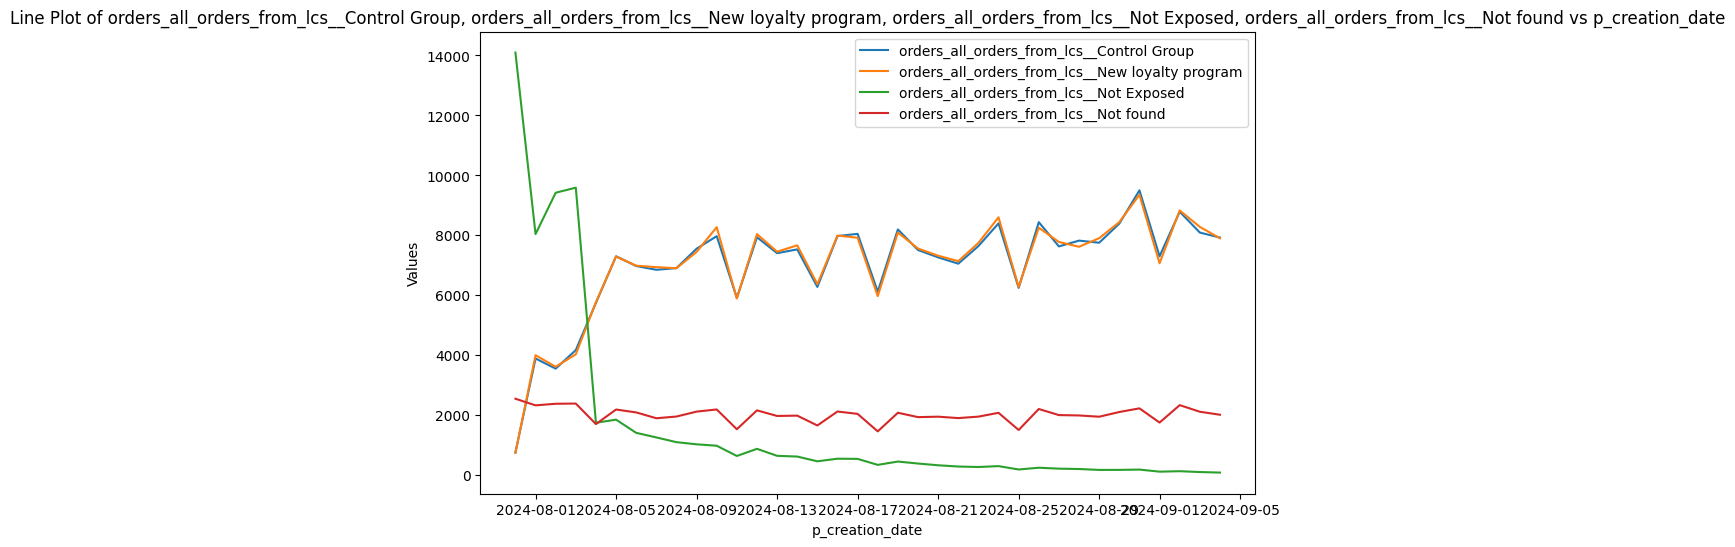

In [192]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-04'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['orders_all_orders_from_lcs','customers_all_orders_from_lcs','gmv_delivered_all_orders_from_lcs'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['orders_all_orders_from_lcs__Control Group', 'orders_all_orders_from_lcs__New loyalty program', 'orders_all_orders_from_lcs__Not Exposed','orders_all_orders_from_lcs__Not found']
)


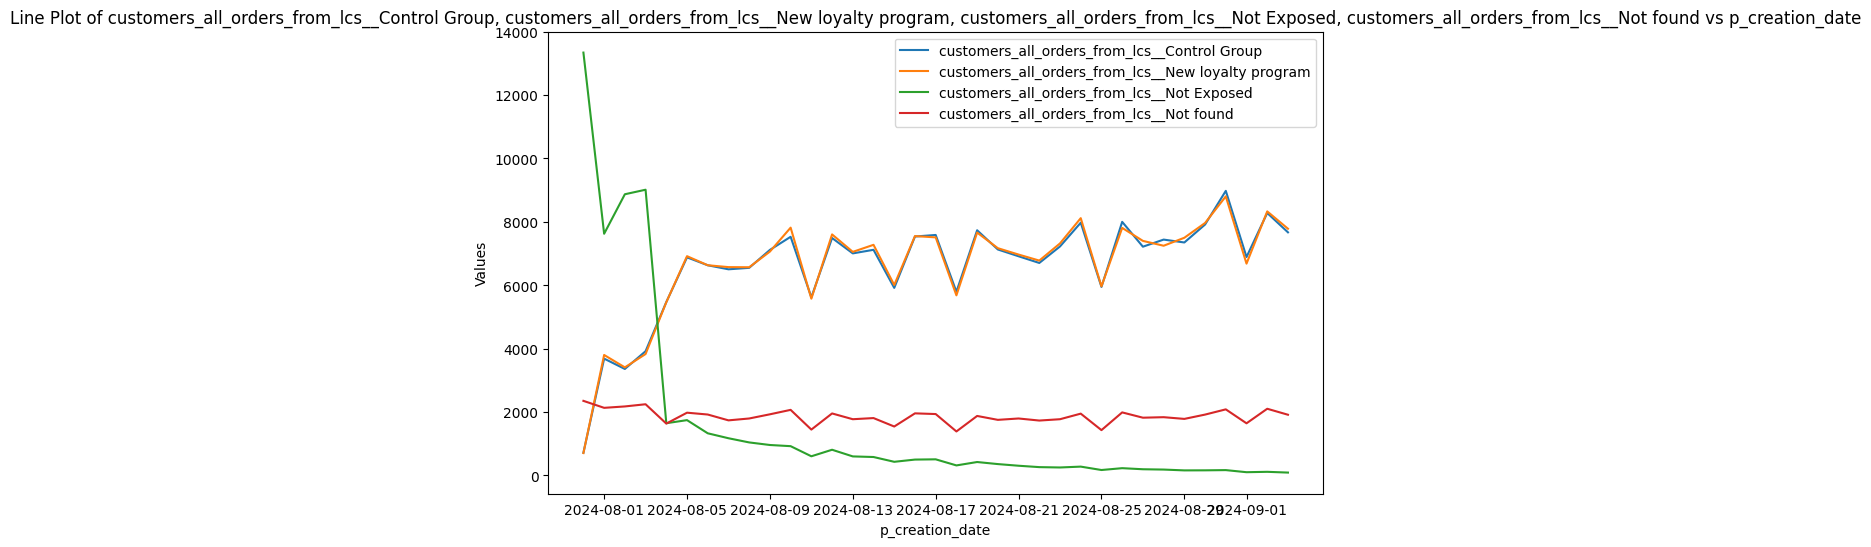

In [178]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-03'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['orders_all_orders_from_lcs','customers_all_orders_from_lcs','gmv_delivered_all_orders_from_lcs'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['customers_all_orders_from_lcs__Control Group', 'customers_all_orders_from_lcs__New loyalty program', 'customers_all_orders_from_lcs__Not Exposed', 'customers_all_orders_from_lcs__Not found']
)


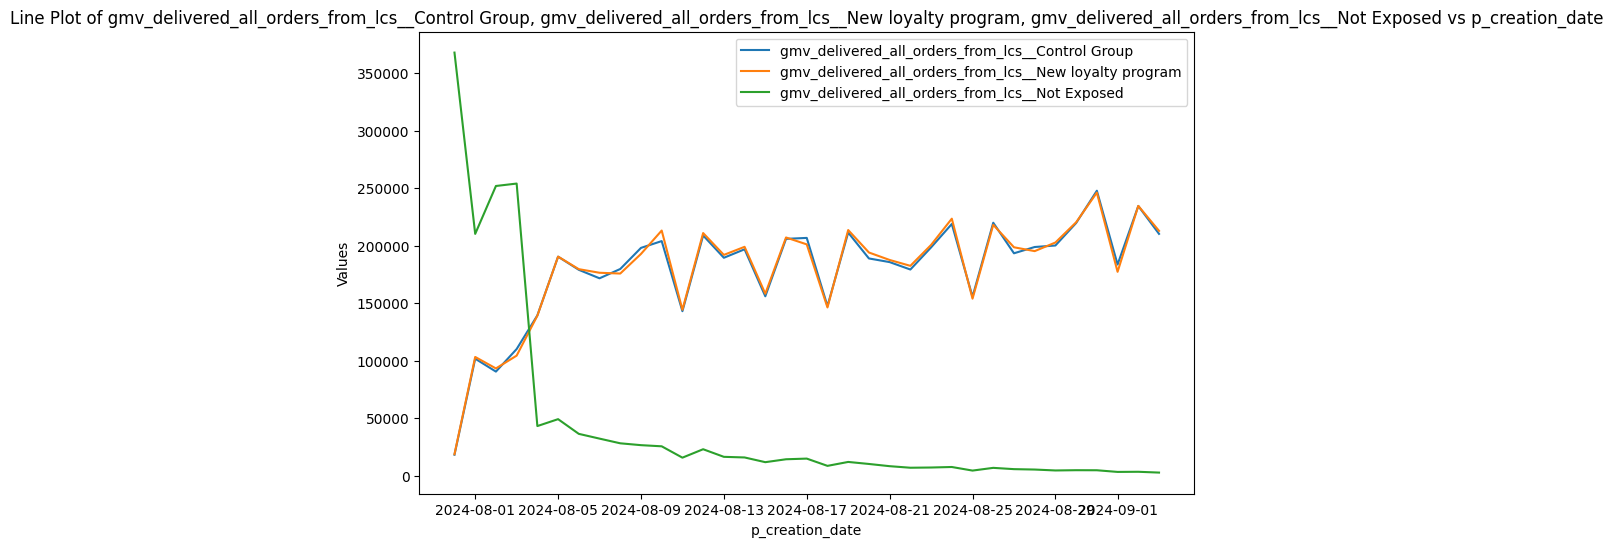

In [154]:
# Time conditions
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-03'

cond1 = df['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

# Pivot by variant
df_pivoted = df[cond1 & cond2].pivot(index='p_creation_date', columns='variant', values=['orders_all_orders_from_lcs','customers_all_orders_from_lcs','gmv_delivered_all_orders_from_lcs'])

# Flatten the multiindex columns 
df_pivoted.columns = [f'{col[0]}__{col[1]}' for col in df_pivoted.columns]

# Reset index to make p_creation_date a regular column
df_pivoted = df_pivoted.reset_index()

v = dataframe_visualizer.DataFrameVisualizer(df_pivoted)
v.multiple_variable_lineplot(
    'p_creation_date'
    ,['gmv_delivered_all_orders_from_lcs__Control Group', 'gmv_delivered_all_orders_from_lcs__New loyalty program', 'gmv_delivered_all_orders_from_lcs__Not Exposed']
)


# Loyalty Cards Main metrics

In [60]:
START_DATE = "'2024-07-31'"
END_DATE = "'2024-09-10'"
PREVIOUS_DAYS_START_DATE = '-30'

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
    {'name':'previous_days_start_date', 'value': PREVIOUS_DAYS_START_DATE},
]

q.prepare_query(
    'lc_analysis/lc_metrics.sql'
    ,params=params
    ,to_load_file='main_metrics'
    ,load_from_to_load_file='main_metrics'
)

df  = q.query_run_starburst()

df.head()

,p_creation_date,store_id,store_name,variant,sa_events_from_lcs,cvr_events_from_lcs,customers_lc_orders_from_lcs,orders_lc_orders_from_lcs,gmv_delivered_lc_orders_from_lcs,customers_all_orders_from_lcs,orders_all_orders_from_lcs,gmv_delivered_all_orders_from_lcs,customers_all_groceries,order_all_groceries,gmv_delivered_all_groceries
0,2024-08-13,91501,Kaufland,Not found,34,7,2.0,2.0,48.752578,7.0,7.0,146.790143,9379,10338,213089.852995
1,2024-09-04,77237,Carrefour,Not found,4,4,NaN,NaN,NaN,4.0,4.0,71.610000,9675,10613,227196.185788
2,2024-08-20,277501,MyAuchan Petrom,Not found,6,0,NaN,NaN,NaN,NaN,NaN,NaN,9305,10260,211095.939142
3,2024-08-18,410107,Duży Ben,Control Group,1,0,NaN,NaN,NaN,NaN,NaN,NaN,33385,36513,688614.861416
4,2024-09-10,394815,Duży Ben,Control Group,1,0,NaN,NaN,NaN,NaN,NaN,NaN,20,24,640.293989


In [61]:
# if there are no values for a given day we add a 0
df = df.fillna(0)
df.head()

# check to make sure that the 4 possible groups exist. They do OK!
df['variant'].value_counts()

variant
New loyalty program    18541
Control Group          18537
Not found              17736
Not Exposed            14721
Name: count, dtype: int64

In [62]:
START_EXPERIMENT = '2024-07-31'
END_EXPERIMENT = '2024-09-04'

# Only keep Control Group and New loyalty program
cond = df['variant'].isin(['Control Group','New loyalty program'])

# Only keep those values
df = df[cond]

# Group and drop values that are not of our interest
df_grouped = df.groupby(['p_creation_date','variant']).sum().reset_index()
df_grouped.drop(['store_id','store_name'],axis=1, inplace=True)

# Compute metrics
df_grouped['cvr'] = df_grouped['cvr_events_from_lcs']/df_grouped['sa_events_from_lcs']
df_grouped['aov_lc_ordres_from_lcs'] = df_grouped['gmv_delivered_lc_orders_from_lcs']/df_grouped['orders_lc_orders_from_lcs']
df_grouped['ratio_lc_orders_per_session'] = df_grouped['orders_lc_orders_from_lcs']/df_grouped['sa_events_from_lcs']
df_grouped['penetration_lc_orders'] = df_grouped['orders_lc_orders_from_lcs']/df_grouped['orders_all_orders_from_lcs']

# Transform p_creation_date into a pd.DataTime
df_grouped['p_creation_date'] = pd.to_datetime(df_grouped['p_creation_date'])

# Transform p_creation_date into a pd.DataTime
df_grouped['p_creation_date'] = pd.to_datetime(df_grouped['p_creation_date'])

# Filter by experiment dates
cond1 = df_grouped['p_creation_date'] >= pd.to_datetime(START_EXPERIMENT)
cond2 = df_grouped['p_creation_date'] <= pd.to_datetime(END_EXPERIMENT)

df_grouped = df_grouped[cond1 & cond2]

# Check of value counts. OK works well
df_grouped['variant'].value_counts()

variant
Control Group          36
New loyalty program    36
Name: count, dtype: int64

## CVR% (Unique sessions with store accessed --> Unique session with order created)

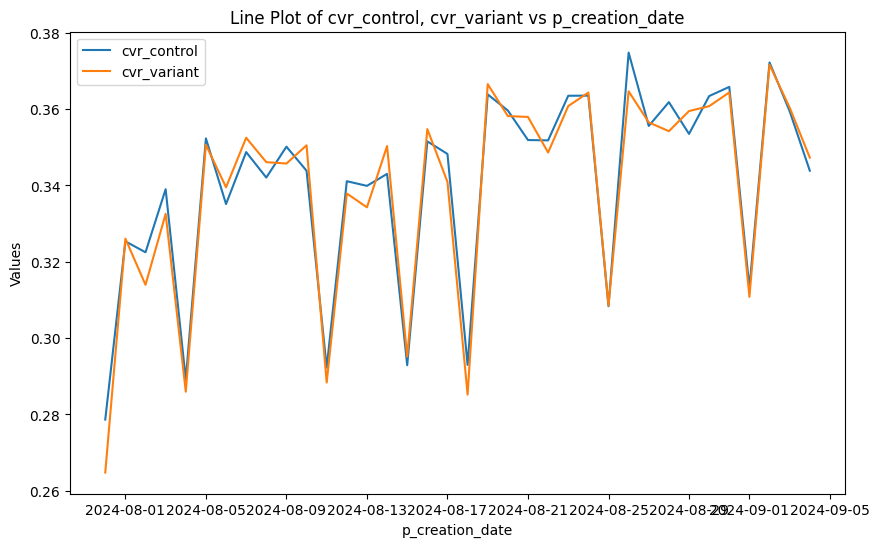

,Group,Mean,Min,Max,Std,Total,Min Non-Null Date,Max Non-Null Date,Null Count,Total Incrementality,Percentual Incrementality (1.0),Mean Incrementality,Mean Percentual Incrementality (1.0),t-statistic,p-value,Significant
0,Control,0.340401,0.278651,0.374790,0.025626,12.254447,2024-07-31,2024-09-04,0,-0.044733,-0.00365,-0.001243,-0.004014,0.198835,0.842971,False
1,Variant,0.339159,0.264761,0.371606,0.027373,12.209714,2024-07-31,2024-09-04,0,-0.044733,-0.00365,-0.001243,-0.004014,0.198835,0.842971,False


In [63]:
# Example usage:
s = dataframe_statistics.DataFrameStatistics(df_grouped)

summary = s.t_test(time_column="p_creation_date", 
                   group_column="variant", 
                   control_name="Control Group", 
                   variant_name="New loyalty program", 
                   metric_column="cvr")

summary

## Ratio (Distinct orders with loyalty cards / distinct sessions store accessed in loyalty cards stores)

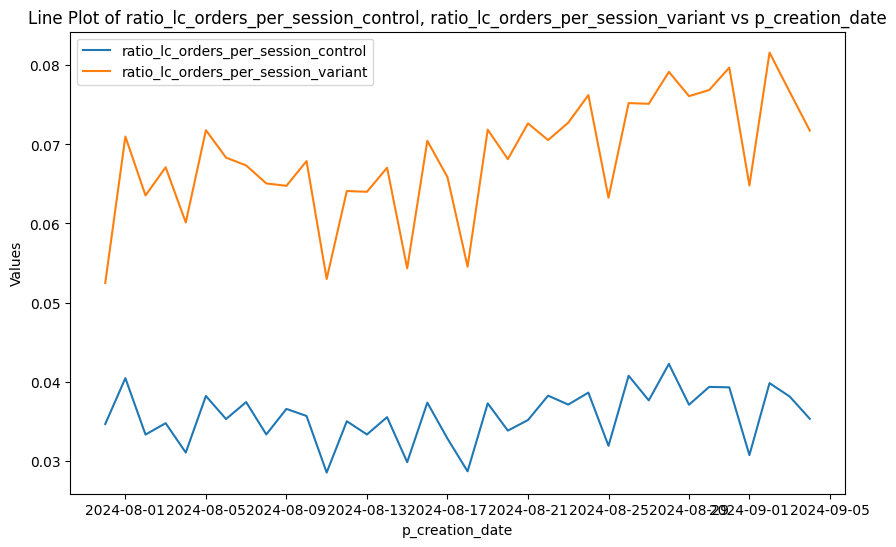

,Group,Mean,Min,Max,Std,Total,Min Non-Null Date,Max Non-Null Date,Null Count,Total Incrementality,Percentual Incrementality (1.0),Mean Incrementality,Mean Percentual Incrementality (1.0),t-statistic,p-value,Significant
0,Control,0.035678,0.028523,0.042253,0.003405,1.284423,2024-07-31,2024-09-04,0,1.180547,0.919126,0.032793,0.919556,-24.026,9.009763e-29,True
1,Variant,0.068471,0.052484,0.081595,0.007448,2.464970,2024-07-31,2024-09-04,0,1.180547,0.919126,0.032793,0.919556,-24.026,9.009763e-29,True


In [64]:
# Example usage:
s = dataframe_statistics.DataFrameStatistics(df_grouped)

summary = s.t_test(time_column="p_creation_date", 
                   group_column="variant", 
                   control_name="Control Group", 
                   variant_name="New loyalty program", 
                   metric_column="ratio_lc_orders_per_session")

summary

## Absolute Distinct orders with loyalty cards

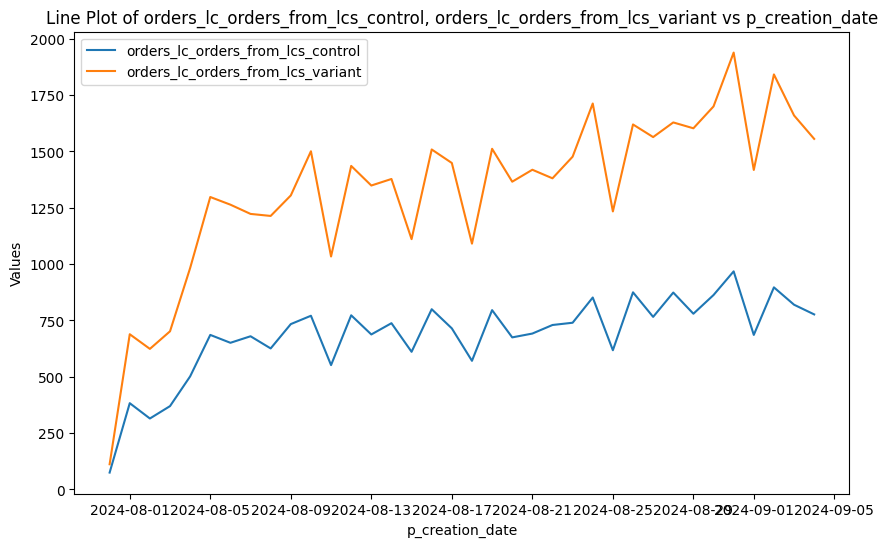

,Group,Mean,Min,Max,Std,Total,Min Non-Null Date,Max Non-Null Date,Null Count,Total Incrementality,Percentual Incrementality (1.0),Mean Incrementality,Mean Percentual Incrementality (1.0),t-statistic,p-value,Significant
0,Control,684.722222,75.0,968.0,179.597584,24650.0,2024-07-31,2024-09-04,0,23255.0,0.943408,645.972222,0.928534,-9.510902,7.002490e-13,True
1,Variant,1330.694444,112.0,1939.0,365.804618,47905.0,2024-07-31,2024-09-04,0,23255.0,0.943408,645.972222,0.928534,-9.510902,7.002490e-13,True


In [65]:
# Example usage:
s = dataframe_statistics.DataFrameStatistics(df_grouped)

summary = s.t_test(time_column="p_creation_date", 
                   group_column="variant", 
                   control_name="Control Group", 
                   variant_name="New loyalty program", 
                   metric_column="orders_lc_orders_from_lcs")

summary

## AOV orders with Loyalty Cards from stores with Loyalty Cards

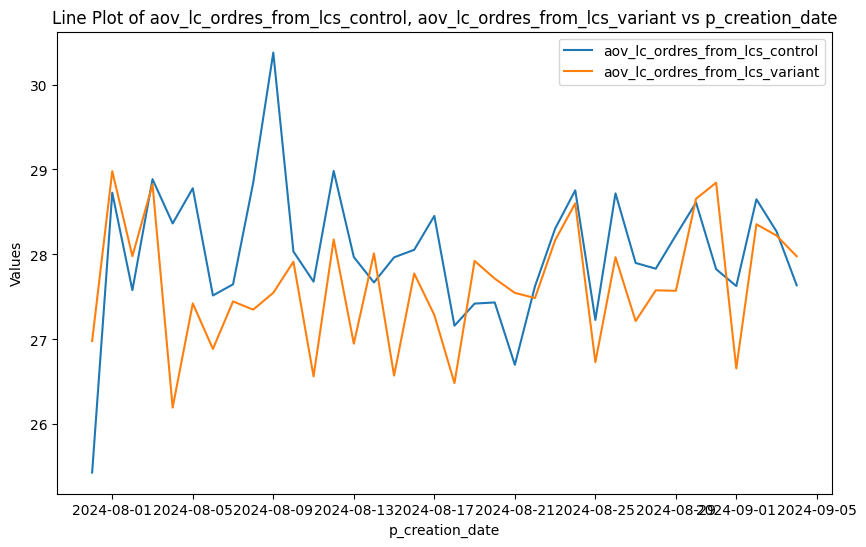

,Group,Mean,Min,Max,Std,Total,Min Non-Null Date,Max Non-Null Date,Null Count,Total Incrementality,Percentual Incrementality (1.0),Mean Incrementality,Mean Percentual Incrementality (1.0),t-statistic,p-value,Significant
0,Control,28.023726,25.430132,30.376233,0.813044,1008.854129,2024-07-31,2024-09-04,0,-14.312953,-0.014187,-0.397582,-0.013645,2.195403,0.0315,True
1,Variant,27.626144,26.196273,28.980078,0.720851,994.541176,2024-07-31,2024-09-04,0,-14.312953,-0.014187,-0.397582,-0.013645,2.195403,0.0315,True


In [46]:
# Example usage:
s = dataframe_statistics.DataFrameStatistics(df_grouped)

summary = s.t_test(time_column="p_creation_date", 
                   group_column="variant", 
                   control_name="Control Group", 
                   variant_name="New loyalty program", 
                   metric_column="aov_lc_ordres_from_lcs")

summary

## (%) Loyalty Card Penetration

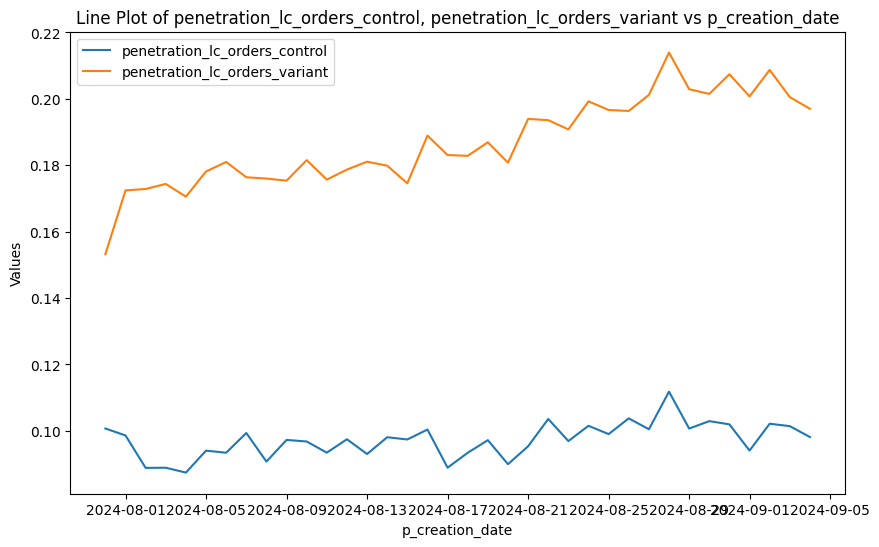

,Group,Mean,Min,Max,Std,Total,Min Non-Null Date,Max Non-Null Date,Null Count,Total Incrementality,Percentual Incrementality (1.0),Mean Incrementality,Mean Percentual Incrementality (1.0),t-statistic,p-value,Significant
0,Control,0.097166,0.087396,0.111779,0.005216,3.497988,2024-07-31,2024-09-04,0,3.230775,0.923609,0.089744,0.924746,-37.664899,6.003979e-36,True
1,Variant,0.186910,0.153215,0.213948,0.013311,6.728763,2024-07-31,2024-09-04,0,3.230775,0.923609,0.089744,0.924746,-37.664899,6.003979e-36,True


In [47]:
# Example usage:
s = dataframe_statistics.DataFrameStatistics(df_grouped)

summary = s.t_test(time_column="p_creation_date", 
                   group_column="variant", 
                   control_name="Control Group", 
                   variant_name="New loyalty program", 
                   metric_column="penetration_lc_orders")

summary